In [1]:
import xarray as xr
from pfct import ClimateStats
from pfct import DefineGrid
from pfct.PlotCart import PlotMaps
from IPython import display

### Ler base de dados observada

In [2]:
file_in = 'precip.mon.mean.nc'  # cmap

with xr.open_mfdataset(file_in) as dset:

    print(dset)

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 511)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-07-01
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(511, 72, 144), meta=np.ndarray>
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (includes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2108
    history:        update08/2021 V2108
    data_modified:  2021-08-06


### Ajuste nas coordenadas da base de dados observadas

In [3]:
# lat: 90:-90 --> -90:90

dset = dset.reindex(lat=dset['lat'][::-1])

In [4]:
# lon: 0:360 --> -180:180

dset['lon_aux'] = xr.where(
    dset['lon'] > 180,
    dset['lon'] - 360,
    dset['lon']
)

dset = (
    dset
        .swap_dims({'lon': 'lon_aux'})
        .sel(**{'lon_aux': sorted(dset.lon_aux)})
        .drop('lon')
)

dset = dset.rename({'lon_aux': 'lon'})

In [5]:
dset

<xarray.Dataset>
Dimensions:  (lat: 72, time: 511, lon: 144)
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-07-01
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(511, 72, 144), meta=np.ndarray>
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (includes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2108
    history:        update08/2021 V2108
    data_modified:  2021-08-06

### Calcular acumulado mensal da base de dados observada

In [6]:
# pr_mon e' um DataArray
# Seleciona os anos 1981 - 2010
pr_mon = dset['precip'].sel(time=slice('1981', '2010'))

In [7]:
# Calcular acumulado mensal
# Multiplica a média mensal (cmap) pela número de dias do mês
pr_total_obs = pr_mon * pr_mon.time.dt.daysinmonth

### Selecionar somente Jan no dado obs

In [8]:
def is_jan(month):
    return (month == 1)

In [9]:
pr_total_obs = pr_total_obs.sel(time=is_jan(pr_total_obs['time.month']))

In [10]:
pr_total_obs.coords['time']  # Verificar eixo do tempo

<xarray.DataArray 'time' (time: 30)>
array(['1981-01-01T00:00:00.000000000', '1982-01-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1984-01-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000', '1986-01-01T00:00:00.000000000',
       '1987-01-01T00:00:00.000000000', '1988-01-01T00:00:00.000000000',
       '1989-01-01T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1992-01-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '1994-01-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '1996-01-01T00:00:00.000000000',
       '1997-01-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1999-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '2001-01-01T00:00:00.000000000', '2002-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2004-01-01T00:00:00.000000000',
       '2005-01-01T00:00:00.000000000', '2006-01-01T00:00:00.000000000',
       '2007-01-01T00:00:00.000000000', '2008-01-01T00:00:00.000000000',
       '2009-01-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1982-01-01 ... 2010-01-01
Attributes:
    long_name:      Time
    delta_t:        0000-01-00 00:00:00
    avg_period:     0000-01-00 00:00:00
    standard_name:  time
    axis:           T
    actual_range:   [1569072. 1941600.]

### Ler dado do modelo

In [11]:
file_in = 'precip.total.ec4.en61.issuejan.jan.1981-2010.nc'  # echam46

with xr.open_mfdataset(file_in) as dset:

    print(dset)

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 30)
Coordinates:
  * lat      (lat) float32 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float32 -177.2 -174.4 -171.6 -168.8 ... 174.4 177.2 180.0
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 25.0 26.0 27.0 28.0 29.0
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(30, 64, 128), meta=np.ndarray>


In [12]:
pr_total_model = dset['precip']

In [13]:
lat = dset['lat'].values  # Sera usado para plotar mapa!

In [14]:
lon = dset['lon'].values  # Sera usado para plotar mapa!

### Interpolar grade observada (2.5° x 2.5°) para grade modelo (~2.8125° x 2.8125°) (T42)

In [15]:
# Parametros DefineGrid sao Numpy Arrays 
arr_obs = DefineGrid.interpol(
    pr_total_obs.values,
    pr_total_obs['lat'].values,
    pr_total_obs['lon'].values,
    pr_total_model['lat'].values,
    pr_total_model['lon'].values,
)

In [16]:
arr_model = pr_total_model.values  # Transforma Numpy Array

In [17]:
arr_obs.shape

(30, 64, 128)

In [18]:
arr_model.shape

(30, 64, 128)

### Calcular correlação

In [19]:
correl = ClimateStats.compute_pearson(arr_model, arr_obs)

In [20]:
correl.shape

(64, 128)

### Calcular Viés

In [21]:
bias = ClimateStats.compute_bias(arr_model, arr_obs)

In [22]:
bias.shape

(64, 128)

### Plot Correlacao

In [23]:
kw = {
    'clevs': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'cmap': ('#FFFFFF', '#AFD9F2', '#FFF5A2', '#FAB416', '#F39300',
             '#EA5C01', '#E5290F', '#C30506', '#703930'),
    'fig_size': (15, 15),
    'parallels': list(range(-180, 181, 30)),
    'meridians': list(range(-90, 91, 20)),
    'dpi': 120,
    'pos_label_y': [-0.05, 0.5],
    'barinf': 'both',
    'shrink_bar': 0.3,
    'fig_title': 'MODEL x OBS',
    'fig_botton': 'CORRELAÇÃO',
    'fig_name': 'correl.png'
}

In [24]:
PlotMaps.plotmaps(correl, lat, lon, **kw)

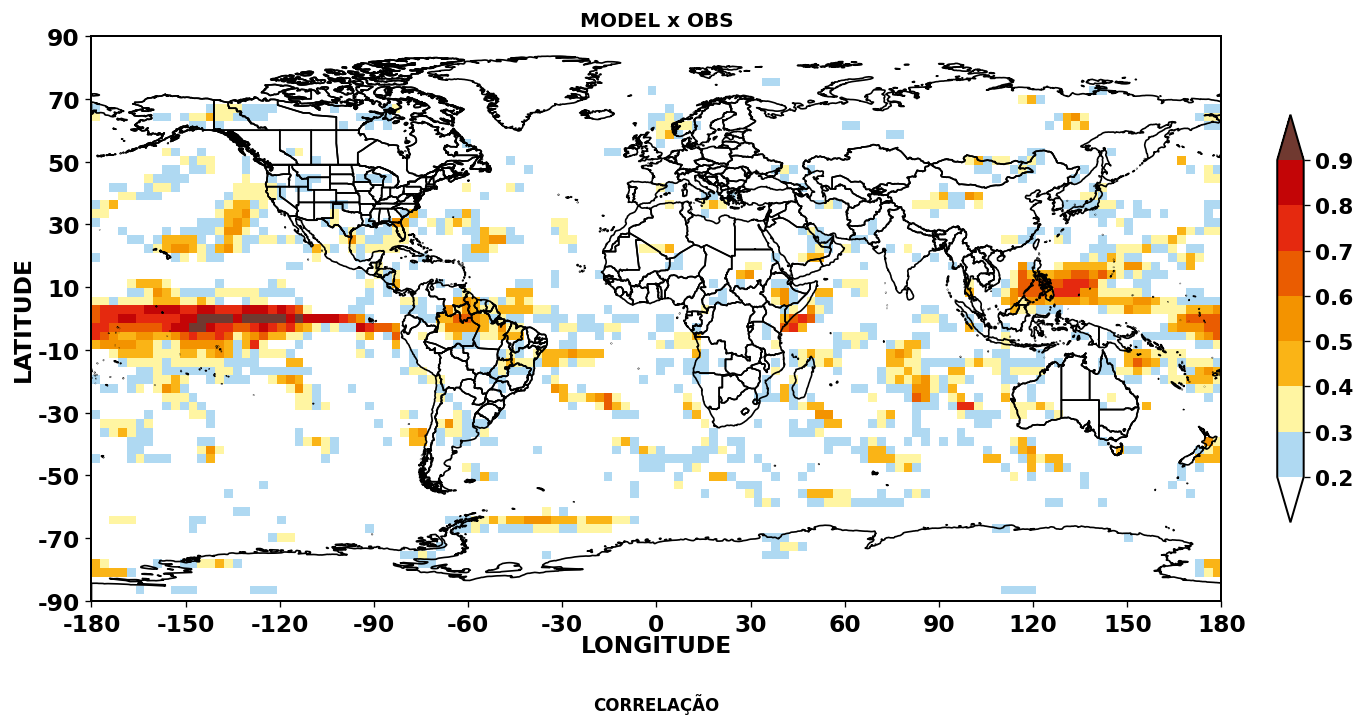

In [25]:
display.Image('correl.png')

### Plot Viés

In [26]:
kw = {
    'clevs': list(range(-260, 261, 40)),
    'cmap': ('#B40426', '#CD423B', '#E26952', '#F08A6C', '#F7A688',
             '#F6BFA6', '#EDD1C2', '#DDDCDC', '#CAD8EF', '#B3CDFB',
             '#9ABBFF', '#81A4FB', '#688AEF', '#516DDB', '#3B4CC0'),
    'fig_size': (13, 13),
    'parallels': list(range(-180, 181, 5)),
    'meridians': list(range(-90, 91, 5)),
    'dpi': 120,
    'pos_label_y': [-0.1, 0.5],
    'barinf': 'both',
    'shrink_bar': 0.7,
    'grid_limits': 'as',
    'focean': True,
    'fig_title': 'MODEL x OBS',
    'fig_botton': 'VIÉS',
    'fig_name': 'vies.png'
}

In [27]:
PlotMaps.plotmaps(bias, lat, lon, **kw)

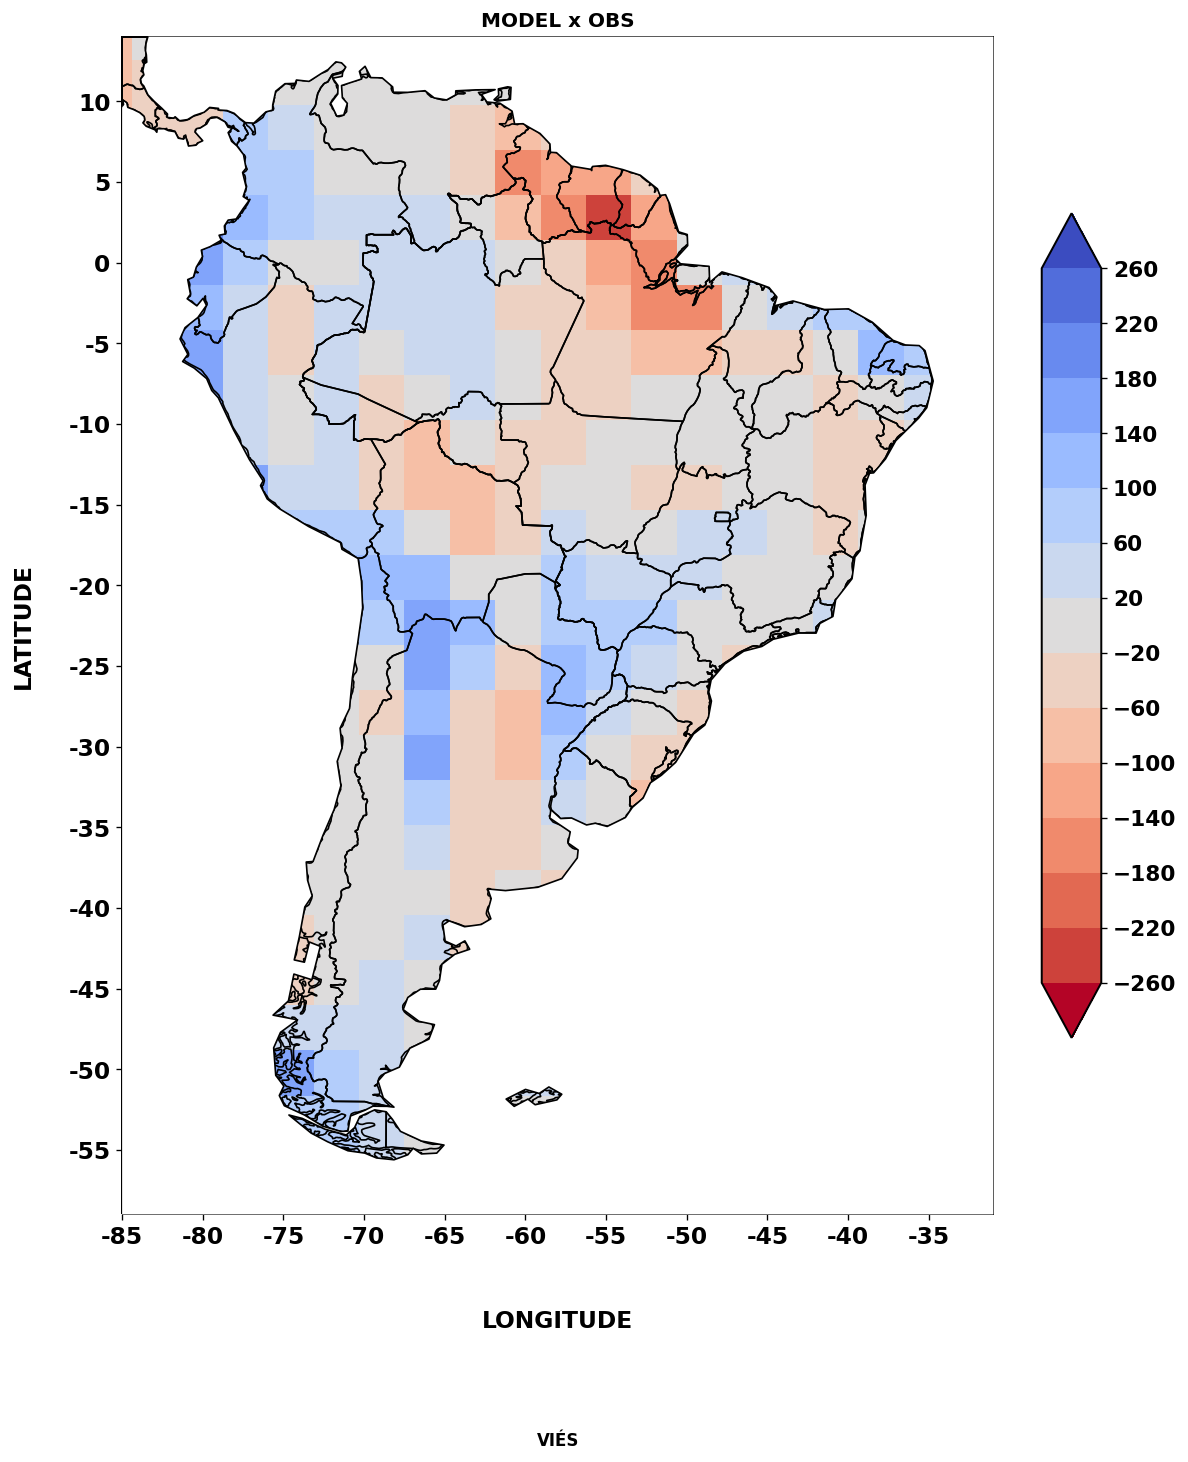

In [28]:
display.Image('vies.png')